In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(sys.path[0])))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import json
from datasets import Dataset

from src.paths import outputp, get_project_root

sns.set_theme(style="whitegrid")

import wandb
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from src.reporting import *

## Load data

In [3]:
wandb.login() # relies on WANDB_API_KEY env var
run = wandb.init(
    project="ea-forum-analysis", job_type="visualization", dir=get_project_root()
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vpetukhov. Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Not Supported


In [4]:
posts = Dataset.load_from_disk(run.use_artifact("posts_raw:latest").download()).to_pandas()

wandb: Downloading large artifact posts_raw:latest, 272.30MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.1


## Raw data visualization

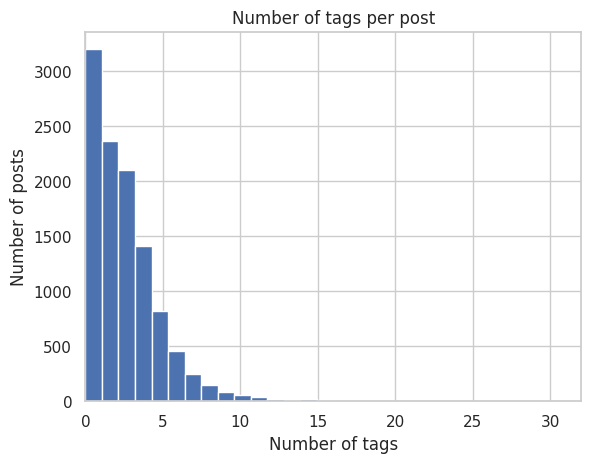

In [5]:
n_tags_per_doc = posts.tags.map(len)
n_tags_per_doc.hist(bins=30);
plt.title('Number of tags per post'); plt.xlabel('Number of tags'); plt.ylabel('Number of posts');
plt.xlim(0, n_tags_per_doc.max());

wandb: ERROR Failed to serialize metric: division by zero


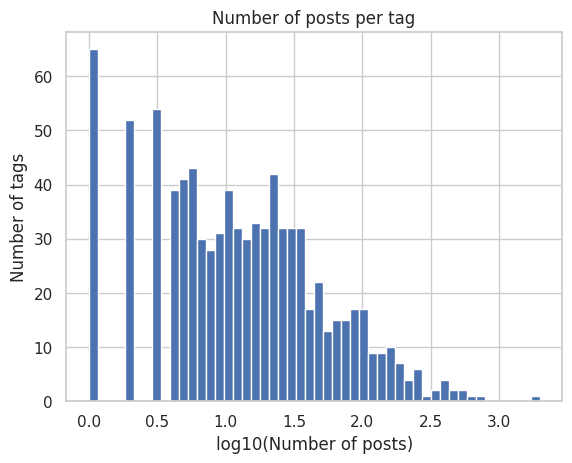

In [6]:
n_docs_per_tag = pd.value_counts(np.concatenate(posts.tags.values))
np.log10(n_docs_per_tag).hist(bins=50);
plt.title('Number of posts per tag'); plt.xlabel('log10(Number of posts)'); plt.ylabel('Number of tags');

/home/vpetukhov/other/Consulting/SEADS/EAForumExperiments/env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


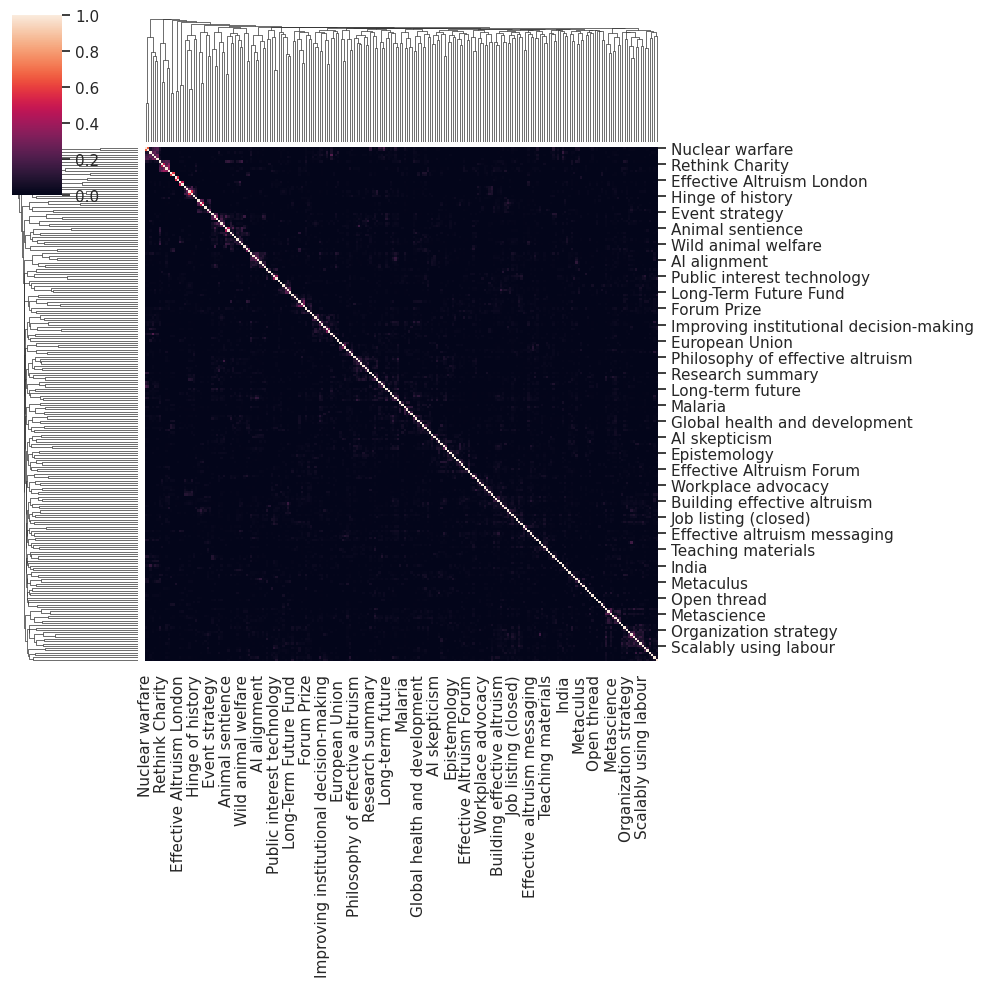

In [7]:
p_tags = n_docs_per_tag.index[n_docs_per_tag > 30]
tag_coocs = estimate_cooccurance_probabilities(posts.tags, symmetric=True, normalize=True).loc[p_tags, p_tags]
cmap = sns.clustermap(tag_coocs);
ord = extract_clustering_from_sns(cmap)[1]
cmap

In [8]:
ntpd_hist = n_tags_per_doc.value_counts().sort_index()
n_tags_per_thres = n_docs_per_tag.sort_values().cumsum()
frac_per_thres = (1 - n_tags_per_thres / n_docs_per_tag.sum()).sort_values()

tag_info_json = {
    'n_tags': {
        'n_tags': list(map(int, ntpd_hist.index)),
        'count': list(map(int, ntpd_hist.values))
    },
    'cum_fracs': {
        'fracs': list(map(float, frac_per_thres.values.round(3))),
        'n_docs': list(map(int, n_docs_per_tag[frac_per_thres.index].values[::-1]))
    },
    'n_docs': list(map(int, n_docs_per_tag.values)),
    'n_docs_total': posts.shape[0],
    'n_tags_total': n_docs_per_tag.size,
    'coocs': extract_tag_heatmap_json(tag_coocs, ord)
}

# with open(outputp('tag_raw_info.json'), 'w') as f:
#     json.dump(tag_info_json, f)

## Extract posts with a lot of tags

In [9]:
posts_filt = posts[n_tags_per_doc > 5]
posts_filt.shape

(1118, 16)

In [10]:
all_tags_filt = n_docs_per_tag.index[(n_docs_per_tag > 30)]
tags_filt = posts_filt.tags.map(np.array).map(lambda x: x[np.in1d(x, all_tags_filt)])
tags_filt = tags_filt[tags_filt.map(len) > 0]

all_tags_filt.size, tags_filt.size

(224, 1117)

/home/vpetukhov/other/Consulting/SEADS/EAForumExperiments/env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


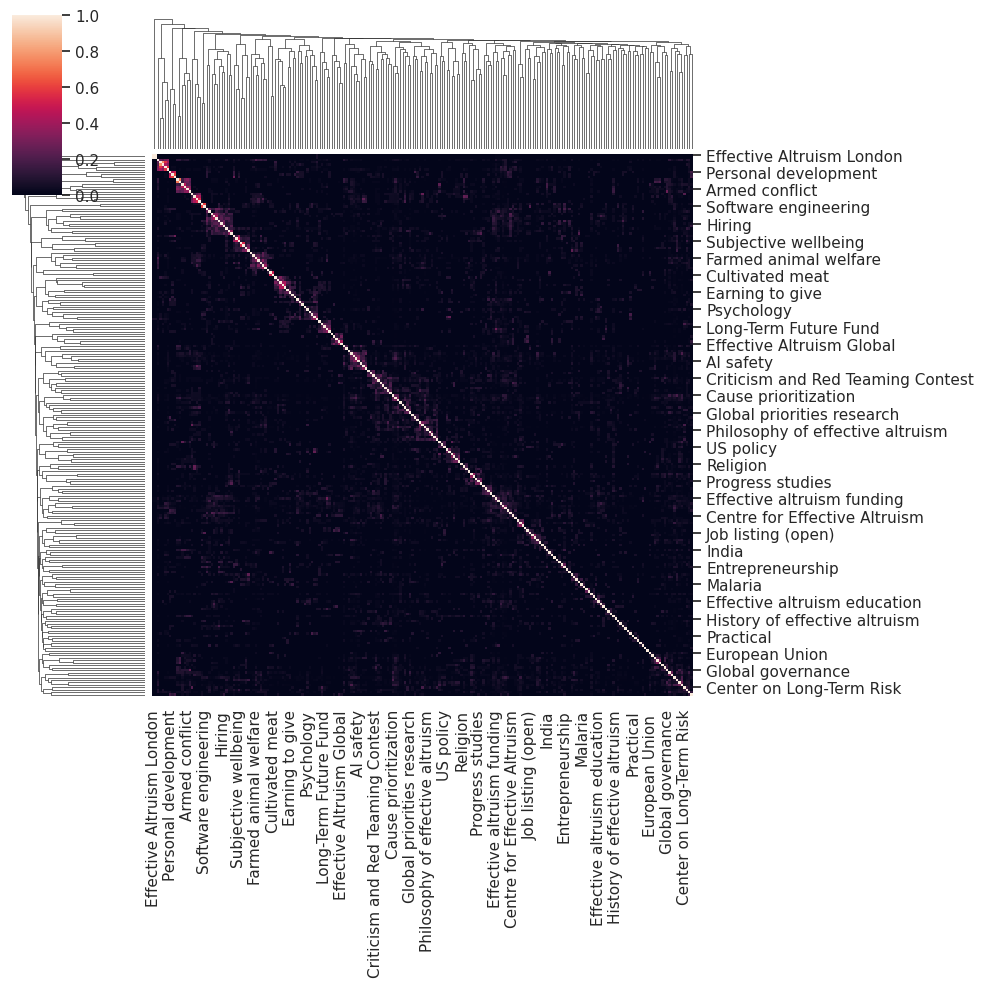

In [11]:
tag_coocs_filt = estimate_cooccurance_probabilities(tags_filt.values, symmetric=True, normalize=True)
cmap = sns.clustermap(tag_coocs_filt)
ord_filt = extract_clustering_from_sns(cmap)[1]
cmap;

In [21]:
tag_dists = 1 - tag_coocs_filt
emb_filt = umap.UMAP(metric='precomputed', spread=2, min_dist=0.1, n_epochs=2000).fit_transform(tag_dists)

/home/vpetukhov/other/Consulting/SEADS/EAForumExperiments/env/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


## Save visualization info

In [22]:
tag_info_json['tag_embedding'] = [
    {'x': float(x), 'y': float(y), 'tag': tag, 'n_docs': int(n_docs)} 
    for tag, (x, y), n_docs in zip(tag_coocs_filt.index, emb_filt, n_docs_per_tag[tag_coocs_filt.index])
]

tag_info_json['coocs_filt'] = extract_tag_heatmap_json(tag_coocs_filt, ord_filt)

with open(outputp('data/tag_info.json'), 'w') as f:
    json.dump(tag_info_json, f)

In [14]:
wandb.finish()